In [ ]:
!pip install gymnasium
!pip install gymnasium[classic-control]

# blackjack
Blackjack is a card game where the goal is to beat the dealer by obtaining cards that sum to closer to 21 (without going over 21) than the dealers cards.
The player can choose to "hit" (take another card) or "stick" (stop taking cards). The dealer must hit until their cards total 17 or higher.
The game is played with an infinite deck (i.e., cards are sampled with replacement).

## card values
- Number cards are worth their face value (2-10)
- Face cards (J, Q, K) are worth 10
- Aces (A) can be worth 1 ('usable ace') or 11

[📖Sutton & Barto: Reinforcement Learning: An Introduction](http://www.incompleteideas.net/book/RLbook2020.pdf)

In [1]:
import gymnasium as gym

# init env
env = gym.make("Blackjack-v1",natural=False, sab=False)
# reset env to generate the first observation
observation, info = env.reset()

# action space is the set of all possible actions the agent can take
print(f"Action space: {[a for a in range(env.action_space.n)]}")  # Discrete(2) - 0: stick, 1: hit
print(f"Sample action: {env.action_space.sample()}")  # random 0 or 1

# observation space defines the format of the observations returned by the environment, in response to the agent's actions
# Tuple(Discrete(32), Discrete(11), Discrete(2))
# - Discrete(32): The player's current sum (possible values: 0-31)
# - Discrete(11): The dealer's visible card (possible values: 1-10, where 1 is Ace, 2-9 cards,10 is 10, J, Q, K)
# - Discrete(2): Whether the player has a usable Ace (0: No, 1: Yes)
print(f"Observation space: {env.observation_space}") 

# Example observation: (20, 10, 0)
# • Player has 20 points
# • Dealer shows a 10 (face card)  
# • Player has no usable ace
# Example observation: (18, 0, 1)
# • Player has 18 points (soft 18: A + 7)
# • Dealer shows an Ace
# • Player has a usable ace (can be counted as 1 if needed)
print(f"Sample observation: {env.observation_space.sample()}")  # random valid observation

env.close()

Action space: [0, 1]
Sample action: 1
Observation space: Tuple(Discrete(32), Discrete(11), Discrete(2))
Sample observation: (10, 6, 0)


episode=10, action=0, observation=(17, 10, 1), reward=-1.0, terminated=True, truncated=False
Total reward: -6.0; win rate: 0.2000


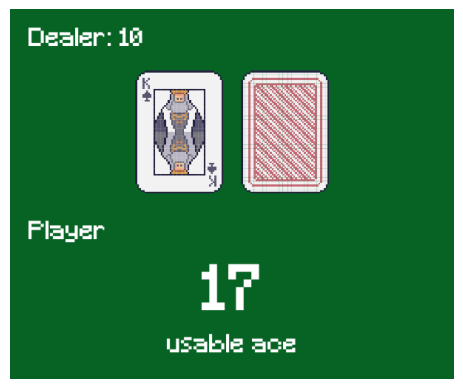

In [2]:
import matplotlib.pyplot as plt
from IPython import display
import gymnasium as gym
%matplotlib inline

# init env
env = gym.make("Blackjack-v1", natural=False, sab=False, render_mode='rgb_array')
# reset env to generate the first observation
observation, info = env.reset()

total_episodes = 0
total_reward = 0
total_wins = 0
for i in range(10+1):
    episode_over = False
    while not episode_over:
        frame = env.render()
        plt.imshow(frame)
        plt.axis('off')
        display.display(plt.gcf())
        display.clear_output(wait=True)     
        
        # random action: we have to improve this!
        action = env.action_space.sample()

        # take the action and see what happens
        # receiving the next observation, reward and if the episode has terminated or truncated
        observation, reward, terminated, truncated, info = env.step(action)
        print(f"episode={i}, action={action}, observation={observation}, reward={reward}, terminated={terminated}, truncated={truncated}")

        # If the episode has ended then we can reset to start a new episode
        # reward: -1 (lose), 0 (draw), +1 (win)
        # terminated: True if the agent has won or lost the game
        # truncated: True if we hit the time limit (500 steps)
        if terminated or truncated:
            total_reward += reward
            if reward > 0:
                total_wins += 1            
            observation, info = env.reset()
            episode_over = True
print(f"Total reward: {total_reward}; win rate: {total_wins/i:.4f}")
env.close()

In [3]:
from collections import defaultdict
import numpy as np

class BlackjackAgent:
    def __init__(
        self,
        env,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action(self, env, obs: tuple[int, int, bool]) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return env.action_space.sample()
        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax(self.q_values[obs]))

    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        """Updates the Q-value of an action."""
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        )

        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

# hyperparameters
learning_rate = 0.001
n_episodes = 1_000_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

agent = BlackjackAgent(
    env=env,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)        

In [16]:
from tqdm import tqdm
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = agent.get_action(env, obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        # update the agent
        agent.update(obs, action, reward, terminated, next_obs)

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

100%|██████████| 1000000/1000000 [02:00<00:00, 8318.49it/s]


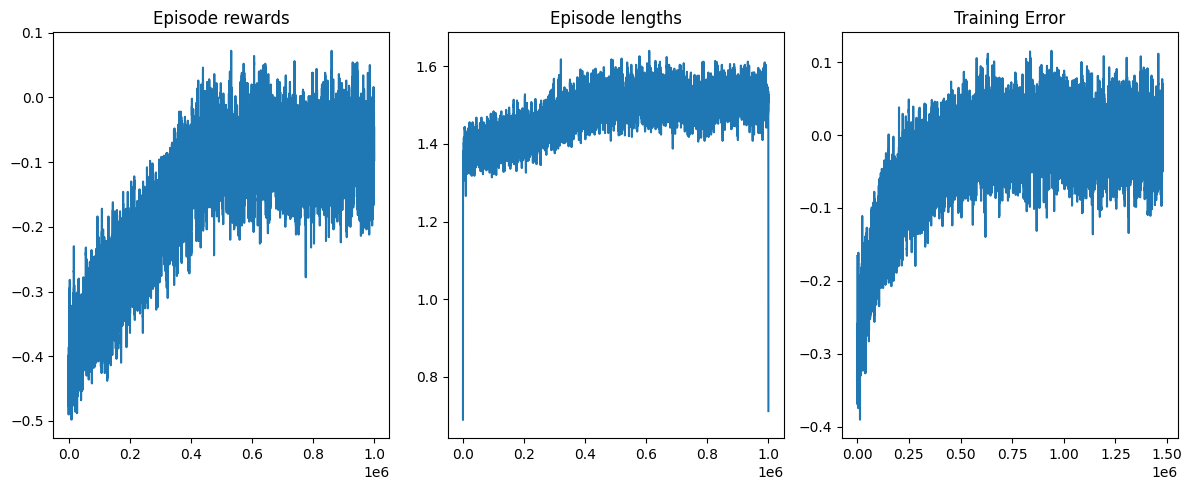

In [17]:
from __future__ import annotations
import matplotlib.pyplot as plt
import numpy as np

rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")
# compute and assign a rolling average of the data to provide a smoother graph
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[2].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
    / rolling_length
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()


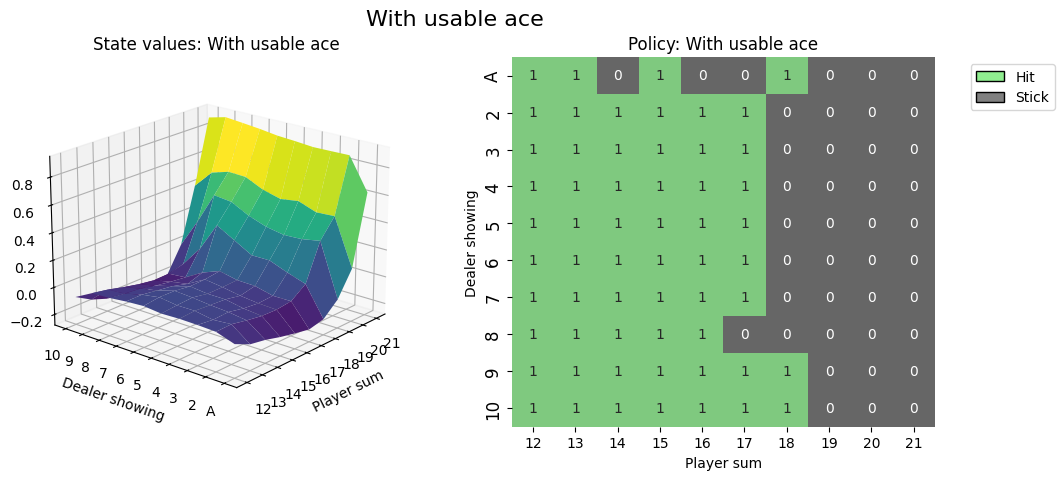

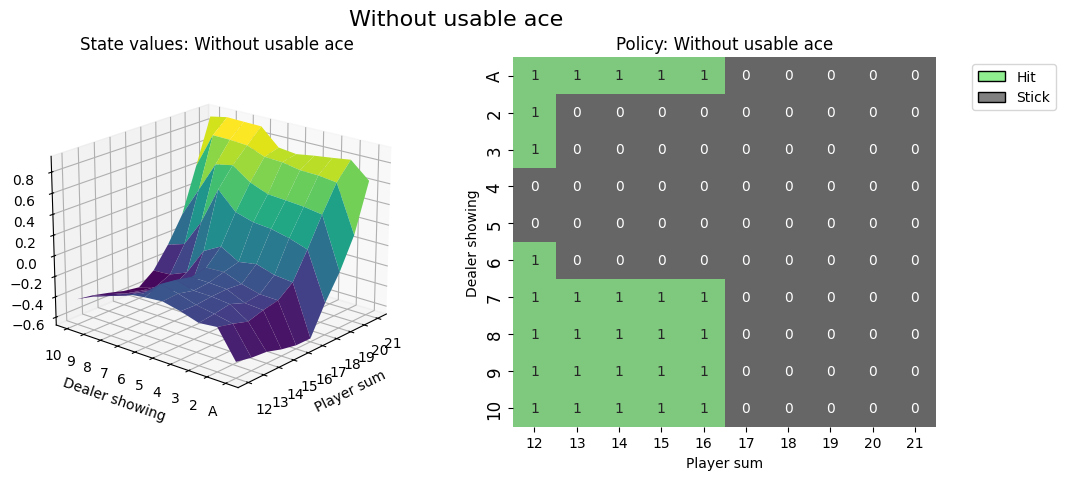

In [42]:
from matplotlib.patches import Patch
import seaborn as sns
def create_grids(agent, usable_ace=False):
    """Create value and policy grid given an agent."""
    # convert our state-action values to state values
    # and build a policy dictionary that maps observations to actions
    state_value = defaultdict(float)
    policy = defaultdict(int)
    for obs, action_values in agent.q_values.items():
        state_value[obs] = float(np.max(action_values))
        policy[obs] = int(np.argmax(action_values))

    player_count, dealer_count = np.meshgrid(
        # players count, dealers face-up card
        np.arange(12, 22),
        np.arange(1, 11),
    )

    # create the value grid for plotting
    value = np.apply_along_axis(
        lambda obs: state_value[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    value_grid = player_count, dealer_count, value

    # create the policy grid for plotting
    policy_grid = np.apply_along_axis(
        lambda obs: policy[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    return value_grid, policy_grid


def create_plots(value_grid, policy_grid, title: str):
    """Creates a plot using a value and policy grid."""
    # create a new figure with 2 subplots (left: state values, right: policy)
    player_count, dealer_count, value = value_grid
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16)

    # plot the state values
    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(
        player_count,
        dealer_count,
        value,
        rstride=1,
        cstride=1,
        cmap="viridis",
        edgecolor="none",
    )
    plt.xticks(range(12, 22), range(12, 22))
    plt.yticks(range(1, 11), ["A"] + list(range(2, 11)))
    ax1.set_title(f"State values: {title}")
    ax1.set_xlabel("Player sum")
    ax1.set_ylabel("Dealer showing")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlabel("Value", fontsize=14, rotation=90)
    ax1.view_init(20, 220)

    # plot the policy
    fig.add_subplot(1, 2, 2)
    ax2 = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False)
    ax2.set_title(f"Policy: {title}")
    ax2.set_xlabel("Player sum")
    ax2.set_ylabel("Dealer showing")
    ax2.set_xticklabels(range(12, 22))
    ax2.set_yticklabels(["A"] + list(range(2, 11)), fontsize=12)

    # add a legend
    legend_elements = [
        Patch(facecolor="lightgreen", edgecolor="black", label="Hit"),
        Patch(facecolor="grey", edgecolor="black", label="Stick"),
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
    return fig


# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(agent, usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()
# state values & policy without usable ace (ace counts as 1)
value_grid, policy_grid = create_grids(agent, usable_ace=False)
fig2 = create_plots(value_grid, policy_grid, title="Without usable ace")
plt.show()

In [18]:
#now play with the learned policy
import gymnasium as gym

# init env
env = gym.make("Blackjack-v1", natural=False, sab=False, render_mode='rgb_array')

def play(total_episodes, learned_policy=True):
    # reset env to generate the first observation
    observation, info = env.reset()
    total_reward = 0
    total_wins = 0
    for i in range(total_episodes+1):
        episode_over = False
        while not episode_over:        
            # action from the learned policy or random
            if learned_policy:
                action = int(np.argmax(agent.q_values[observation]))                
            else:
                action = env.action_space.sample()

            observation, reward, terminated, truncated, info = env.step(action)
            #print(f"episode={i}, action={action}, observation={observation}, reward={reward}, terminated={terminated}, truncated={truncated}")

            if terminated or truncated:
                total_reward += reward
                if reward > 0:
                    total_wins += 1            
                observation, info = env.reset()
                episode_over = True
    print(f"learned_policy:{learned_policy} reward: {total_reward}; win rate: {total_wins/i:.4f} over {i} episodes")
    env.close()

def compare_policies(total_episodes):
    play(total_episodes=total_episodes, learned_policy=True)
    play(total_episodes=total_episodes, learned_policy=False)

compare_policies(10_000)

learned_policy:True reward: -462.0; win rate: 0.4325 over 10000 episodes
learned_policy:False reward: -3912.0; win rate: 0.2832 over 10000 episodes
